<a href="https://colab.research.google.com/github/m-wessler/nbm-verification/blob/main/NBM4p1_Percentile_Context.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NBM Percentile in Context**
A script to grab NBM percentile data, deterministic forecast and obs, and put the obs or deterministic forecast into the context of Probabilistic NBM space. Feel free to steal or use as a springboard for you own endeavours.
Contact me if you need help walking through it - caleb.steele@noaa.gov

-*Caleb Steele - NWS WR STID - 14-Feb-2022*
<br/> <br/>
Updates:

> 12-Aug-2022: Pretty significant update that changed much of the underlying code. Files used are now grib files (instead of the geotiffs used before), which are larger and take longer to download and decode. The gribs include more percentiles, and a cubic spline is utilized vs linear interpolation now, so the NBM distribution is much better sampled. While all 99 percentiles are avaiable, trimmed it to use 13 (1st, 5th, 10th, 20th, 30th, etc.) to save some time. If you are more patient, you can dig into the code and swap out the lists (uncomment one, uncomment the other) that will use all 99, but it will take awhile. In my limited tests, it offers little improvement in the representation of the CDF/PDF. Also wrapped everything up behind a form and added light/dark mode option. Finally, added an option to generate a csv from the dataframe that is created (helpful to make sure it has done what you expect).

> 7-Apr-2022: Added QPF, but still a lot of cleanup required. If you select Deterministic and QPF, it will really use the percentile mean. Will clean it up to use the deterministic, and add percentile mean as a separate option at some point.

> 18-Feb-2022: Added option of adding CWA boundaries, cleaned up the directories (by actually making some), and more plot tweaks so they all look as expected.

> 17-Feb-2022: fixed a hard coded reference that lead to the histogram always displaying the observation percentile distribution, even when deterministic was selected in regional plots.

> 16-Feb-2022: added "compare_to" variable which lets you switch between comparing obs and NBM determinsitic to the ProbMaxT Percentiles.






Feel free to steal or use as a springboard for you own endeavours.
Contact me if you need help walking through it - caleb.steele@noaa.gov

This first cell just imports everything we need. **NOTE: This cell will restart the notebook, which will prompt a crash popup in the lower left corner. This is safe to ignore and move on once the notebook comes back up** (you see RAM and Disk in the upper right corner).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:16
🔁 Restarting kernel...


In [1]:
!mamba install -q -c conda-forge cartopy contextily pyproj pyepsg pygrib netCDF4
import numpy as np
from scipy.interpolate import CubicSpline as cs, UnivariateSpline as us
import pandas as pd
from urllib.request import urlretrieve, urlopen
import requests
from datetime import datetime, timedelta
import json
from netCDF4 import Dataset
import pygrib
import pyproj
from pyproj import Proj, transform
import os, re, traceback

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
import seaborn as sns

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import contextily as cx
import itertools

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/site-packages/conda_package_streaming/package_streaming.py:19: UserWarning: zstandard could not be imported. Running without .conda support.
  warnings.warn("zstandard could not be imported. Running without .conda support.")
/usr/local/lib/python3.10/site-packages/conda_package_handling/api.py:29: UserWarning: Install zstandard Python bindings for .conda support
  _warnings.warn("Install zstandard Python bindings for .conda support")
/usr/local/lib/python3.10/site-packages/conda_package_streaming/package_streaming.py:19: UserWarning: zstandard could not be imported. Running without .conda support.
  warnings.warn("zstandard could not be imported. Running without .conda support.")
/usr/local/lib/python3.10/site-packages/conda_package_handling/api.py:29: UserWarning: Install zstandard Python bindings for .conda support
  _warnings.warn("Install zstandard Python bindings for .conda support")


Getting obs...
   > Grabbing obs for:  WR
Getting and processing NBM...
   > Getting NBM deterministic
   > Downloading a subset of NBM gribs
https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20231108/00/qmd/blend.t00z.qmd.f192.co.grib2
./nbm/blend.t00z.qmd.20231108_0020231108_00f192.co.qpf_subset.grib2
      ✅ Success! Searched for [:APCP:surface:7-8 day acc fcst:] and got [110] GRIB fields and saved as ./nbm/blend.t00z.qmd.20231108_0020231108_00f192.co.qpf_subset.grib2
     >> Extracting NBM deterministic
   > NBM probabilistic already exists
   > Extracting NBM Probabilistic
     >> Extracting NBM P1
     >> Extracting NBM P5
     >> Extracting NBM P10
     >> Extracting NBM P20
     >> Extracting NBM P30
     >> Extracting NBM P40
     >> Extracting NBM P50
     >> Extracting NBM P60
     >> Extracting NBM P70
     >> Extracting NBM P80
     >> Extracting NBM P90
     >> Extracting NBM P95
     >> Extracting NBM P99
Creating point distribution curves and interpolating...
   > Creat

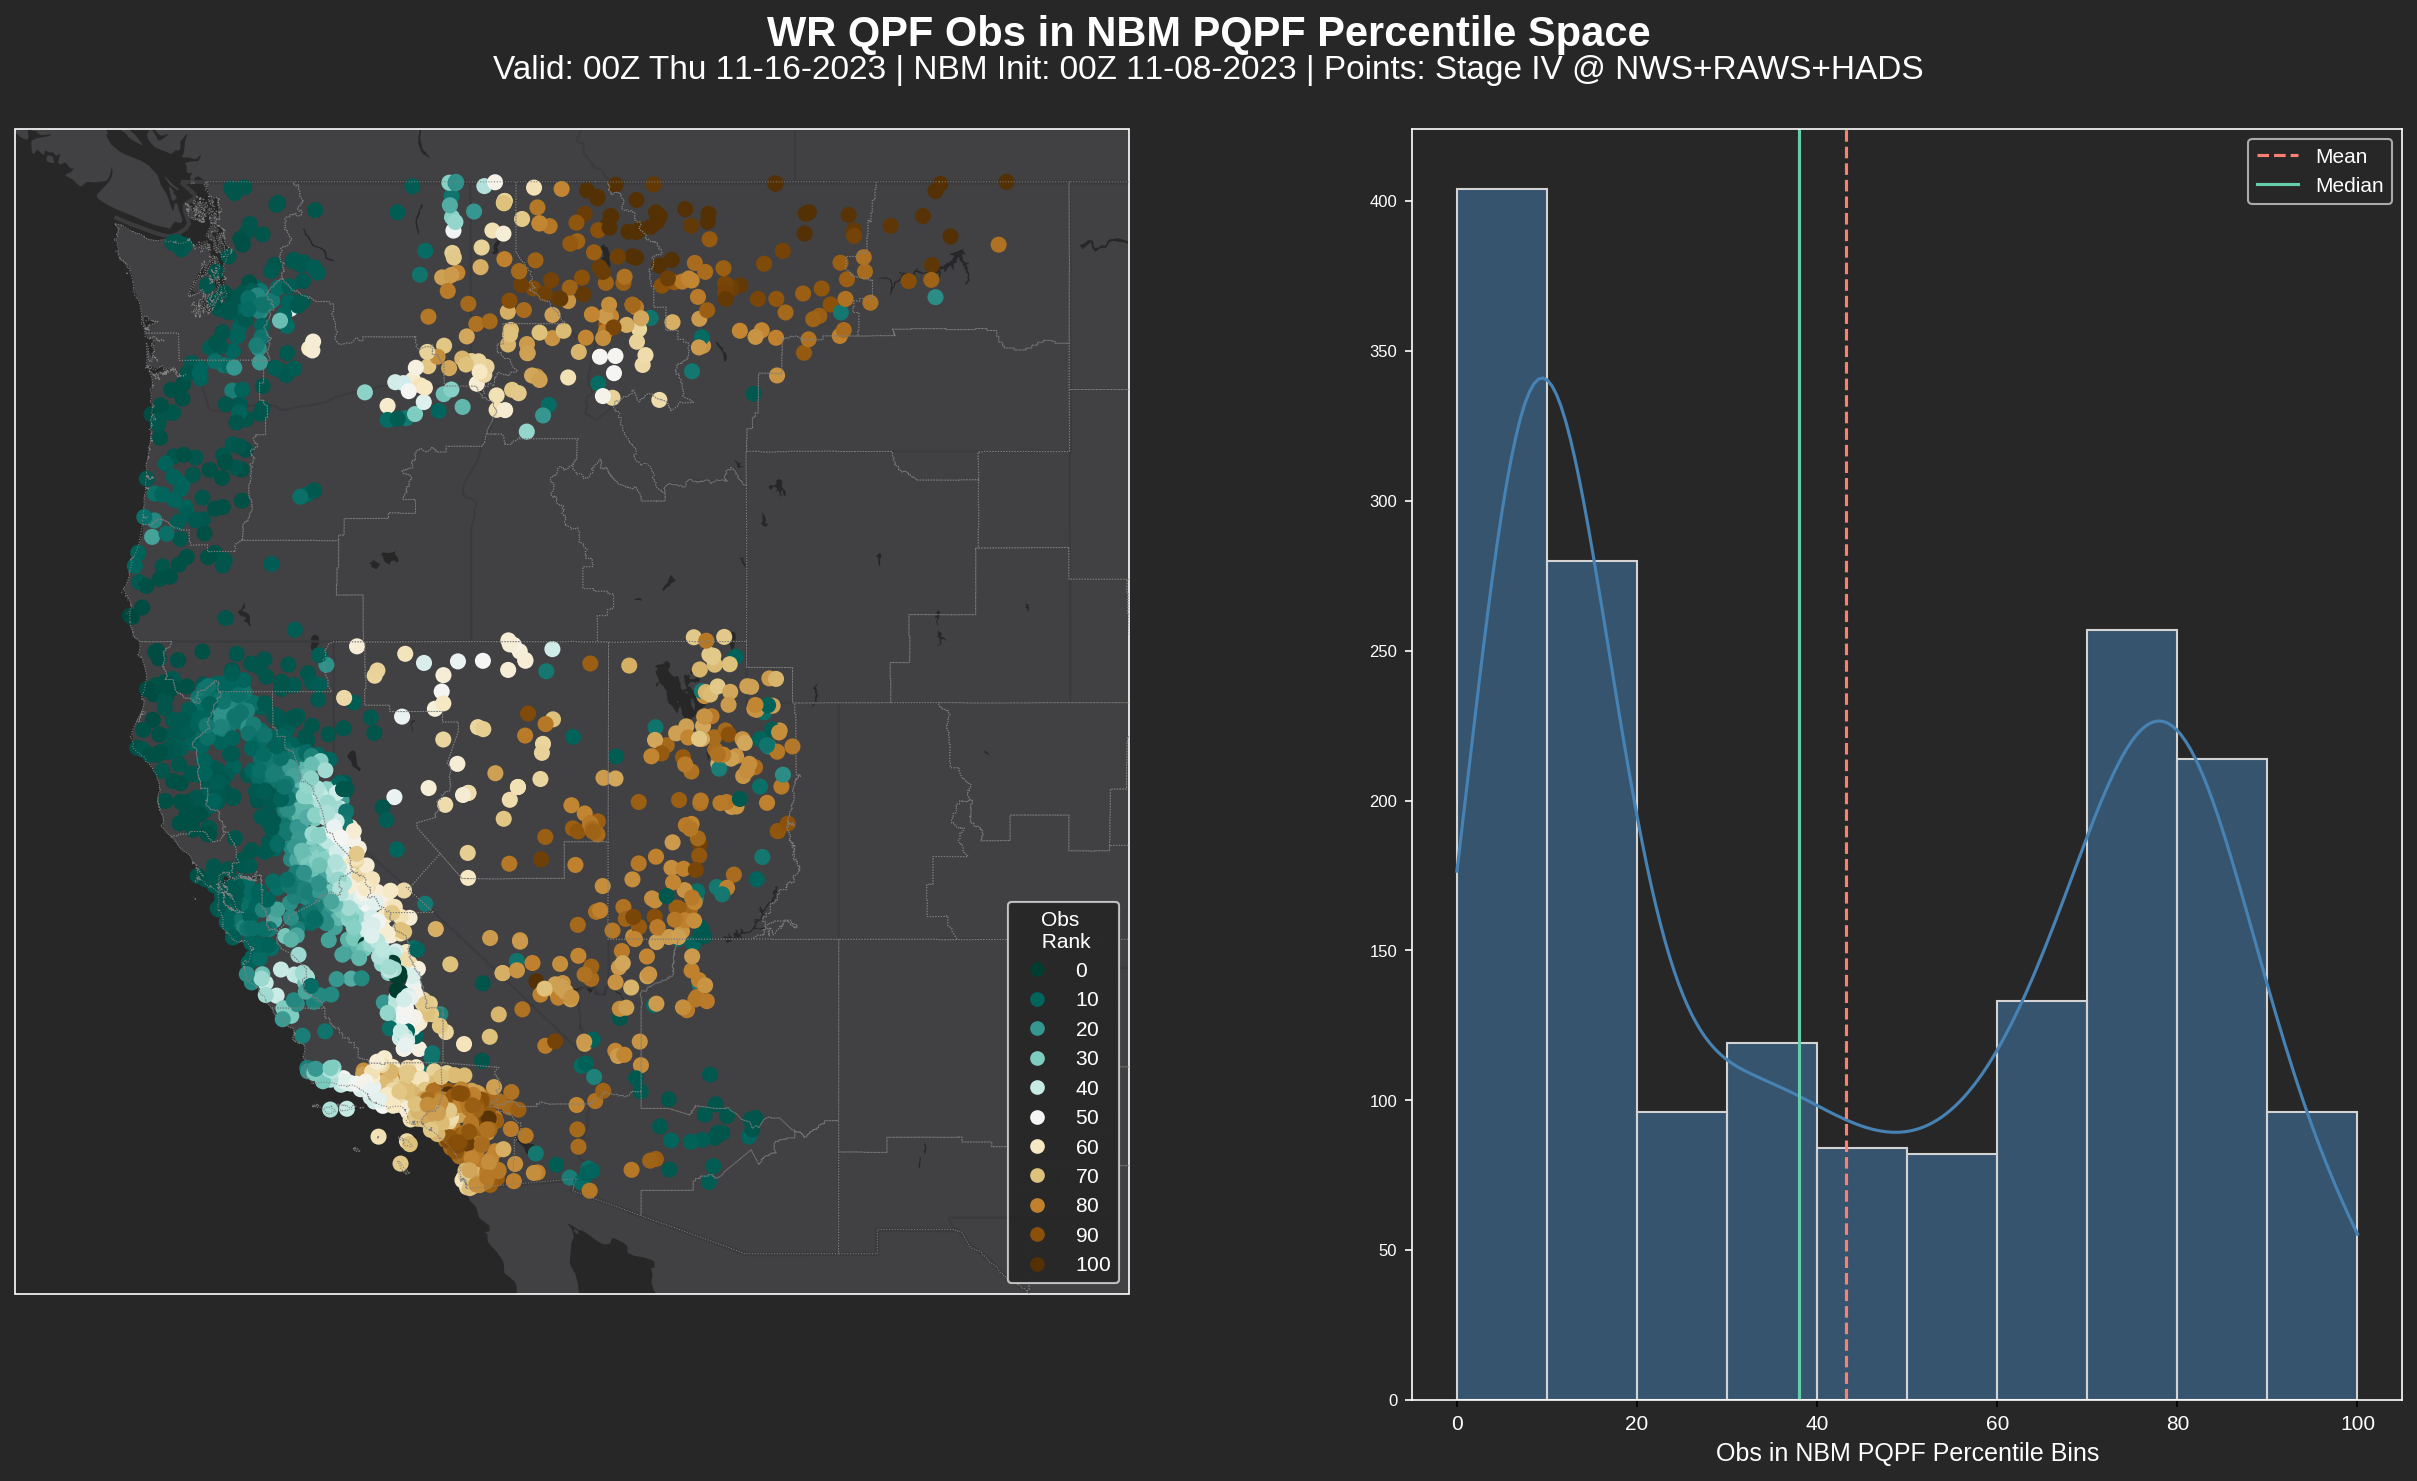

In [7]:
#@title Options Selection { display-mode: "form" }
element = "qpf" #@param ["maxt", "mint","qpf"]
valid_date = "2023-11-16" #@param {type:"date"}
#@markdown QPF valid 24 hours ending time
qpf_valid_time = 00 #@param {type:"slider", min:0, max:18, step:6}
#@markdown Use StageIV at stations instead of obs?
use_stageiv = True #@param {type:"boolean"}
#@markdown Pick NBM run time
nbm_init_date = "2023-11-08" #@param {type:"date"}
nbm_init_hour = 00 #@param {type:"slider", min:0, max:18, step:6}
#@markdown Where do you want to focus?
region_selection = "WR" #@param ["WR", "SR", "CR", "ER", "CONUS", "CWA"]
#@markdown If CWA selected, which one? (i.e. "SLC" for Salt Lake City)
cwa_id = "bgm" #@param {type:"string"}
compare_to = "obs" #@param ["obs", "deterministic"]
#@markdown Which obs?
network_selection = "NWS+RAWS+HADS" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
#@markdown If Custom or List selected for network, enter comma separated network IDs (custom) or siteids (list)  WITH NO SPACES here. For help - https://developers.synopticdata.com/about/station-providers/
network_input = "KSLC,KU42,KCDC,KSGU"#@param {type:"string"}
cwa_outline = True #@param {type:"boolean"}
#@markdown Do you want a CSV?
export_csv = True #@param {type:"boolean"}
#@markdown Light or dark theme plots?
plot_style = "dark" #@param ["light", "dark"]

if region_selection == "CONUS":
  region_list = ["WR", "CR", "SR", "ER"]
elif region_selection == "CWA":
  region_list = [cwa_id]
else:
  region_list = [region_selection]

def cwa_list(input_region):
  region_dict ={"WR":"BYZ,BOI,LKN,EKA,FGZ,GGW,TFX,VEF,LOX,MFR,MTR,MSO,PDT,PSR,PIH,PQR,REV,STO,SLC,SGX,HNX,SEW,OTX,TWC",
              "CR":"ABR,BIS,CYS,LOT,DVN,BOU,DMX,DTX,DDC,DLH,FGF,GLD,GJT,GRR,GRB,GID,IND,JKL,EAX,ARX,ILX,LMK,MQT,MKX,MPX,LBF,APX,IWX,OAX,PAH,PUB,UNR,RIW,FSD,SGF,LSX,TOP,ICT",
              "ER":"ALY,LWX,BGM,BOX,BUF,BTV,CAR,CTP,RLX,CHS,ILN,CLE,CAE,GSP,MHX,OKX,PHI,PBZ,GYX,RAH,RNK,AKQ,ILM",
              "SR":"ABQ,AMA,FFC,EWX,BMX,BRO,CRP,EPZ,FWD,HGX,HUN,JAN,JAX,KEY,MRX,LCH,LZK,LUB,MLB,MEG,MFL,MOB,MAF,OHX,LIX,OUN,SJT,SHV,TAE,TBW,TSA"}
  if (input_region in ["WR", "CR", "SR", "ER"]):
    cwas_list = region_dict[input_region]
  else:
    cwas_list = input_region
  return cwas_list




nbm_init = datetime.strptime(nbm_init_date,'%Y-%m-%d') + timedelta(hours=int(nbm_init_hour))


if element == "maxt":
    nbm_core_valid_hour="00"
    nbm_qmd_valid_hour="06"
    valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
    valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
    obs_start_hour = "1200"
    obs_end_hour = "0600"
    ob_stat = "maximum"
    valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
    nbm_core_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_core_valid_hour))
    nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
    core_init = nbm_init + timedelta(hours = 7)
    nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init

elif element == "mint":
    nbm_core_valid_hour="12"
    nbm_qmd_valid_hour="18"
    valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
    valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d')
    obs_start_hour = "0000"
    obs_end_hour = "1800"
    ob_stat = "minimum"
    valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
    nbm_core_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_core_valid_hour))
    nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
    core_init = nbm_init + timedelta(hours = 7)
    nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init

elif element == "qpf":
    nbm_core_valid_hour = str(qpf_valid_time)
    nbm_valid_hour = str(qpf_valid_time)
    nbm_qmd_valid_hour=str(qpf_valid_time)
    valid_date = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=int(qpf_valid_time))
    valid_date_start = valid_date - timedelta(hours=24)
    valid_date_end = valid_date
    obs_start_hour = obs_end_hour = f'{qpf_valid_time:02d}00' #str(qpf_valid_time)+"00"
    # obs_end_hour = #str(qpf_valid_time)+"00"
    ob_stat = "total"
    valid_end_datetime = valid_date_end
    core_init = nbm_init
    nbm_core_valid_end_datetime = valid_date_end
    nbm_qmd_valid_end_datetime = valid_date_end
    nbm_core_fhdelta = nbm_core_valid_end_datetime - nbm_init

current_datetime = datetime.now()

nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
nbm_core_forecasthour_start = nbm_core_forecasthour - 12
nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
if element == "qpf":
  nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 24
else:
  nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 18

nbm_qmd_forecasthour = abs(nbm_qmd_forecasthour)

synoptic_token = "a2386b75ecbc4c2784db1270695dde73"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"

# Setup a dictionary for translating a form selection into a something we can pass to mesowest API
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":"", "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]

if element == "qpf":
  cmap = 'BrBG_r'
else:
  cmap = 'Spectral'
if use_stageiv and element=="qpf":
  points_str = f'Stage IV @ {network_selection}'
else:
  points_str = network_selection

if plot_style=="light":
  background_color = '#f7f7f7'
  text_color = '#121212'
  map_land_color = '#FAFAF8'
  map_water_color = '#D4DBDD'
  map_border_color = 'grey'
elif plot_style=="dark":
  background_color = '#272727'
  text_color = 'white'
  map_land_color = '#414143'
  map_water_color = '#272727'
  map_border_color = '#3B3B3D'


########################################################################################################################
# Reusable functions section                                                                                           #
########################################################################################################################

def project3(lon, lat, prj):
  lon = float(lon)
  lat = float(lat)

  outproj = prj
  inproj = Proj(init='epsg:4326')
  nbm_coords = transform(inproj, outproj, lon, lat)
  coordX = nbm_coords[0]
  coordY = nbm_coords[1]
  #print(f'Lat: {lat}, Y: {coordY} | Lon: {lon}, X: {coordX}')
  return(coordX, coordY)


def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)


def project_hrap(lon, lat, s4x, s4y):
  lon = float(lon)
  lat = float(lat)

  globe = ccrs.Globe(semimajor_axis=6371200)
  hrap_ccrs = proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=255.0,
                          true_scale_latitude=60.0, globe=globe)
  latlon_ccrs = ccrs.PlateCarree()
  hrap_coords = hrap_ccrs.transform_point(lon,lat,src_crs=latlon_ccrs)
  hrap_idx = ll_to_index(s4x, s4y, hrap_coords[0], hrap_coords[1])

  return hrap_idx


def get_stageiv():
  siv_url = "https://water.weather.gov/precip/downloads/"+valid_date_end.strftime('%Y')+"/"+valid_date_end.strftime('%m')+"/"+valid_date_end.strftime('%d')+"/nws_precip_1day_"+valid_date_end.strftime('%Y%m%d')+"_conus.nc"
  data = urlopen(siv_url).read()

  nc = Dataset('data', memory=data)
  #with Dataset(siv_file, 'r') as nc:
  stageIV = nc.variables['observation']
  s4x = nc.variables['x']
  s4y = nc.variables['y']
  return stageIV, s4x, s4y


def K_to_F(kelvin):
  fahrenheit = 1.8*(kelvin-273)+32.
  return fahrenheit


def mm_to_in(millimeters):
  inches = millimeters * 0.0393701
  return inches


def find_roots(x,y):
  s = np.abs(np.diff(np.sign(y))).astype(bool)
  return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)


# This bit of code to subset the grib and only download things we want is
# shamelessly stolen from Brian Blaylock (https://github.com/blaylockbk)
def download_subset(remote_url, remote_file, local_file):
  local_file = './nbm/' + local_file

  print("   > Downloading a subset of NBM gribs")
  print(remote_url)
  print(local_file)

  if "qmd" in remote_file:
    if element == "maxt":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "mint":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:'
    elif element == "qpf":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
      else:
        search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
  elif "core" in remote_file:
    if element == "maxt":
      search_string = f':TMAX:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour max fcst:'
    elif element == "mint":
      search_string = f':TMIN:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour min fcst:'
  #print(search_string)
  idx = remote_url+".idx"
  r = requests.get(idx)
  if not r.ok:
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
      # n is the line number (starting from 1) so that when we call for
      # `lines[n]` it will give us the next line. (Clear as mud??)

      # Use the compiled regular expression to search the line
      if expr.search(line):
          # aka, if the line contains the string we are looking for...

          # Get the beginning byte in the line we found
          parts = line.split(':')
          rangestart = int(parts[1])

          # Get the beginning byte in the next line...
          if n+1 < len(lines):
              # ...if there is a next line
              parts = lines[n].split(':')
              rangeend = int(parts[1])
          else:
              # ...if there isn't a next line, then go to the end of the file.
              rangeend = ''

          # Store the byte-range string in our dictionary,
          # and keep the line information too so we can refer back to it.
          byte_ranges[f'{rangestart}-{rangeend}'] = line
          #print(line)
  for i, (byteRange, line) in enumerate(byte_ranges.items()):

        if i == 0:
            # If we are working on the first item, overwrite the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
        else:
            # If we are working on not the first item, append the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
        try:
          num, byte, date, var, level, forecast, _ = line.split(':')
        except:
          pass

        #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')
        os.system(curl)

  if os.path.exists(local_file):
      print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
      return local_file
  else:
      print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))



########################################################################################################################
# This section for downloading and processing obs                                                                      #
########################################################################################################################
print('Getting obs...')
obs={}
for region in region_list:
  if (valid_end_datetime <= current_datetime):
    print("   > Grabbing obs for: ", region)
    #print("List of CWAs: ", cwa_list(region) )
    json_name = "obs/Obs_"+element+"_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+region+".json"
    if os.path.exists("obs"):
      pass
    else:
      !mkdir obs

    if element != "qpf":
      api_token = "&token="+synoptic_token
      station_query = "&cwa="+cwa_list(region)
      vars_query = "&vars=air_temp"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      api_extras = "&units=temp%7Cf&within=1440&status=active"
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query + api_extras
    elif element == "qpf":
      if use_stageiv:
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        stageIV, s4xs, s4ys = get_stageiv()
        s4xs, s4ys = np.meshgrid(s4xs, s4ys)
      else:
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras

        print(start_query, end_query)
        print(obs_url)

      #print(obs_url)
    if os.path.exists(json_name):
      pass
    else:
      urlretrieve(obs_url, json_name)

    if os.path.exists(json_name):
        with open(json_name) as json_file:
            obs_json = json.load(json_file)
            obs_lats = []
            obs_lons = []
            obs_value = []
            obs_elev = []
            obs_stid = []
            obs_name = []
            for stn in obs_json["STATION"]:
                # print(stn.encode('utf-8'))
                if stn["STID"] is None:
                  stid = "N0N3"
                else:
                  stid = stn["STID"]
                #print(f'Processing {region} station {stid}')
                name = stn["NAME"]
                if stn["ELEVATION"] and stn["ELEVATION"] is not None:
                  elev = stn["ELEVATION"]
                else:
                  elev = -999
                lat = stn["LATITUDE"]
                lon = stn["LONGITUDE"]
                if element == "mint" or element=="maxt":
                  if 'air_temp_set_1' in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
                    if ob_stat in stn['STATISTICS']['air_temp_set_1'] and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
                      stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(float(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      obs_value.append(float(stat))
                elif (element == "qpf"):
                  if (stn["STATUS"] == "ACTIVE") and float(stn["LATITUDE"]) < 50.924 and float(stn["LATITUDE"]) > 23.377 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
                    obs_stid.append(str(stid))
                    obs_name.append(str(name))
                    obs_elev.append(float(elev))
                    obs_lats.append(float(lat))
                    obs_lons.append(float(lon))
                    if use_stageiv:
                      coords = project_hrap(lon, lat, s4xs, s4ys)
                      siv_value = float(stageIV[coords])
                      if (siv_value >= 0.01):
                        obs_value.append(siv_value)
                      else:
                        obs_value.append(np.NaN)
                    else:
                      if "precipitation" in stn["OBSERVATIONS"]:
                        if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                          ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                          if ptotal >= 0.01:
                            obs_value.append(ptotal)
                          else:
                            obs_value.append(np.nan)
                        else:
                          obs_value.append(np.nan)
                      else:
                        obs_value.append(np.nan)



            csv_name = "obs_"+element+"_"+region+".csv"
            obs[region] = pd.DataFrame()
            obs[region]["stid"] = obs_stid
            obs[region]["name"] = obs_name
            obs[region]["elevation"] = obs_elev
            obs[region]["lat"] = obs_lats
            obs[region]["lon"] = obs_lons
            obs[region]["ob_"+element] = obs_value
            #obs[region].to_csv(csv_name)
  else:
    print(f'    > Valid Time in the future. Grabbing obs points only for: {region}')
    json_name = "obs/ObsPoints_"+region+".json"
    if os.path.exists(json_name):
      pass
    else:
      if os.path.exists("obs"):
        pass
      else:
        !mkdir obs
      obs_url = "https://api.synopticdata.com/v2/stations/metadata?&token="+synoptic_token+"&cwa="+cwa_list(region)+"&fields=status,latitude,longitude,name,elevation"+network_string
      urlretrieve(obs_url, json_name)
    if os.path.exists(json_name):
      with open(json_name) as json_file:
          obs_json = json.load(json_file)
          obs_lats = []
          obs_lons = []
          obs_elev = []
          obs_stid = []
          obs_name = []
          for stn in obs_json["STATION"]:
            # print(stn.encode('utf-8'))
            if stn["STID"] is None:
              stid = "N0N3"
            else:
              stid = stn["STID"]
            #print(f'Processing {region} station {stid}')
            name = stn["NAME"]
            if stn["ELEVATION"] and stn["ELEVATION"] is not None:
              elev = stn["ELEVATION"]
            else:
              elev = -999
            lat = stn["LATITUDE"]
            lon = stn["LONGITUDE"]
            if stn["STATUS"] == "ACTIVE" and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
              obs_stid.append(str(stid))
              obs_name.append(str(name))
              obs_elev.append(int(elev))
              obs_lats.append(float(lat))
              obs_lons.append(float(lon))
          obs[region] = pd.DataFrame()
          obs[region]["stid"] = obs_stid
          obs[region]["name"] = obs_name
          obs[region]["elevation"] = obs_elev
          obs[region]["lat"] = obs_lats
          obs[region]["lon"] = obs_lons
          obs[region]["ob_"+element] = -999
          #obs[region].to_csv(csv_name)

########################################################################################################################
# This section downloads and processes the NBM.                                                                        #
########################################################################################################################
print('Getting and processing NBM...')
nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
nbm_init_filen_core = core_init.strftime('%Y%m%d') + "_" + core_init.strftime('%H')
nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
            +"/"+nbm_init.strftime('%H')+"/"
nbm_url_base_core = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
            +"/"+core_init.strftime('%H')+"/"
temp_vars = ["maxt","mint"]
if (element == "qpf"):
  detr_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2'
  detr_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.co.{element}_subset.grib2'
  detr_url = nbm_url_base+"qmd/"+detr_file

elif any(te in element for te in temp_vars):
  detr_file = f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.co.grib2"
  detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.co.{element}_subset.grib2"
  detr_url = nbm_url_base_core+"core/"+detr_file


if os.path.exists("nbm/"+detr_file_subset):
  print("   > NBM deterministic already exists")
else:
  print("   > Getting NBM deterministic")
  if os.path.exists("nbm"):
    pass
  else:
    !mkdir nbm
  #urlretrieve(detr_url, "nbm/"+detr_file)
  download_subset(detr_url, detr_file, detr_file_subset)
#print(detr_url)
nbmd = pygrib.open("nbm/"+detr_file_subset)
if element == "maxt":
  deterministic = nbmd.select(name="Maximum temperature",lengthOfTimeRange=12, stepTypeInternal="max")[0]
  deterministic_array = K_to_F(deterministic.values)
elif element == "mint":
  deterministic = nbmd.select(name="Minimum temperature",lengthOfTimeRange=12, stepTypeInternal="min")[0]
  deterministic_array = K_to_F(deterministic.values)
elif element == "qpf":
  deterministic = nbmd.select(name="Total Precipitation",lengthOfTimeRange=24)[-1]
  deterministic_array = mm_to_in(deterministic.values)
nbmlats, nbmlons = deterministic.latlons()
nbmd.close()

for region in region_list:
  print("     >> Extracting NBM deterministic")
  point_lats = obs[region]["lat"].values
  point_lons = obs[region]["lon"].values
  detr_values = []
  nbm_fidx = []
  for i in range(0, len(point_lats)):
    coords = ll_to_index(nbmlons, nbmlats, point_lons[i], point_lats[i])
    detr_value = deterministic_array[coords]
    nbm_fidx.append(coords)
    detr_values.append(detr_value)
  obs[region]["NBM_fidx"] = nbm_fidx
  obs[region]["NBM_D"] = detr_values


perc_list = [1,5,10,20,30,40,50,60,70,80,90,95,99]
#perc_list = range(1,100,1)
perc_dict = {"maxt":"maxt18p", "mint":"mint18p", "qpf":"qpf24p"}
perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2'
perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.co.{element}_subset.grib2'
perc_url = nbm_url_base+"qmd/"+perc_file
if os.path.exists("nbm/"+perc_file_subset):
  print("   > NBM probabilistic already exists")
else:
  #urlretrieve(perc_url, "nbm/"+perc_file)
  print("   > Getting NBM probabilistic")
  download_subset(perc_url, perc_file, perc_file_subset)

nbmperc = pygrib.open("nbm/"+perc_file_subset)
print('   > Extracting NBM Probabilistic')
for perc in perc_list:
  print(f'     >> Extracting NBM P{int(perc):01}')
  perc_name = "NBM_P"+str(perc)
  if element == "maxt":
    percdata = K_to_F(nbmperc.select(name="2 metre temperature", stepTypeInternal="max", percentileValue=perc)[0].values)
  elif element == "mint":
    percdata = K_to_F(nbmperc.select(name="2 metre temperature", stepTypeInternal="min", percentileValue=perc)[0].values)
  elif element == "qpf":
    percdata = mm_to_in(nbmperc.select(name="Total Precipitation",lengthOfTimeRange=24, percentileValue=perc)[0].values)
  for region in region_list:
    nbm_coords = obs[region]["NBM_fidx"].values
    perc_values = []
    for i in range(0, len(nbm_coords)):
      perc_value = percdata[nbm_coords[i]]
      perc_values.append(perc_value)
    obs[region][perc_name] = perc_values
nbmperc.close()


########################################################################################################################
# This section creates a distribution curve at each site, and interpolates ob and deterministic to percentile space    #
########################################################################################################################
print('Creating point distribution curves and interpolating...')
for region in region_list:
  perc_start = obs[region].columns.get_loc("NBM_P1")
  perc_end = obs[region].columns.get_loc("NBM_P99")
  all_percs = obs[region].iloc[:, perc_start:perc_end+1].values
  var_string = "ob_"+element
  all_obs = obs[region][[var_string]].values
  all_nbmd = obs[region][['NBM_D']].values
  obs_percs = []
  nbmd_percs = []
  for i in range(0,len(all_obs)):
    udf = us(perc_list, all_percs[i,:], bbox=[0,100], ext=0)
    if all_obs[i] <= udf(0):
      ob_perc = 0
    elif all_obs[i] >= udf(100):
      ob_perc = 100
    else:
      ob_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_obs[i])
      ob_perc = ob_perc[0].round(1)

    if all_nbmd[i] <= udf(0):
      nbm_perc = 0
    elif all_nbmd[i] >= udf(100):
      nbm_perc = 100
    else:
      nbm_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_nbmd[i])
      nbm_perc = nbm_perc[0].round(1)

    if np.isnan(ob_perc):
      obs_percs.append(ob_perc)
    else:
      obs_percs.append(int(ob_perc))
    nbmd_percs.append(int(nbm_perc))
  obs[region]["ob_perc"] = obs_percs
  obs[region]["NBMd_perc"] = nbmd_percs
  if export_csv:
    csv_name = "obs_"+element+"_"+valid_end_datetime.strftime('%Y%m%d')+"_"+region+".csv"
    obs[region].to_csv(csv_name)
    print(f'   > Created and saved {csv_name}')


########################################################################################################################
# Finally, this section makes our plot.                                                                                #
########################################################################################################################
print("Making plot (almost done!)...")
if compare_to =="obs":
  compare_var = "ob_perc"
  compare_element = "Obs"
elif compare_to == "deterministic":
  compare_var = "NBMd_perc"
  if element =="qpf":
    compare_element = "pMean"
  else:
    compare_element = "Detr"

title_dict = {"maxt":["Max T","PMaxT"],"mint":["Min T","PMinT"], "qpf":["QPF","PQPF"]}
matplotlib.rc('axes',facecolor=background_color, edgecolor=text_color)
if (element == "qpf"):
  valid_datetime = valid_date
  fig_valid_date = valid_datetime.strftime('%Y%m%d_%HZ')
  valid_title = valid_datetime.strftime('%HZ %a %m-%d-%Y')
else:
  valid_datetime = datetime.strptime(valid_date,'%Y-%m-%d')
  fig_valid_date = valid_datetime.strftime('%Y%m%d')
  valid_title = valid_datetime.strftime('%a %m-%d-%Y')
nbm_init_title = nbm_init.strftime('%HZ %m-%d-%Y')

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

if region_selection == "CONUS":
  dataframeid = "CONUS"
  #set up multipanel plot
  west =-125.650
  south = 23.377
  east = -66.008
  north = 50.924
  width_ratios = [7,3,3,3]
  lloc = "lower right"
  fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor=background_color, frameon=True, dpi=150)
  grid = fig.add_gridspec(4,4, width_ratios=width_ratios, hspace=0.2, wspace=0.2, left=0.1, right=0.9)
  fig.text(0.30, 0.885,f'{region_selection} {title_dict[element][0]} {compare_element} in NBM {title_dict[element][1]} Percentile Space',horizontalalignment='center',weight='bold',fontsize=25,color=text_color)
  fig.text(0.30, 0.855,f'Valid: {valid_title}  |  NBM Init: {nbm_init_title}  |  Points: {points_str}',horizontalalignment='center',fontsize=16,color=text_color)

  ax1 = fig.add_subplot(grid[:,:-2], projection=ccrs.Mercator(globe=None))
  ax2 = fig.add_subplot(grid[0,2])
  ax3 = fig.add_subplot(grid[0,3])
  ax4 = fig.add_subplot(grid[1,2])
  ax5 = fig.add_subplot(grid[1,3])
  ax6 = fig.add_subplot(grid[2:,2:])

  conus_df = pd.concat([obs["WR"], obs["CR"], obs["ER"],obs["SR"]])
  lats = conus_df["lat"].values
  lons = conus_df["lon"].values
  point_data = conus_df[compare_var].values
  mean = conus_df[compare_var].mean()
  median = conus_df[compare_var].median()
  mode = conus_df[compare_var].mode().values[0]

  proj = ccrs.PlateCarree()

  ax1.set_anchor('S')
  ax1.set_extent([west, east, south, north], crs=proj)
  #ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
  ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
  #ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
  ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=1)
  #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
  ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=2))
  #cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
  scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj)
  #handles, labels = scatter.legend_elements(num=10)
  #legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
  legend1 = ax1.legend(*scatter.legend_elements(num=10), loc=lloc, title=f'{compare_element} \n Rank', fancybox=True)
  plt.setp(legend1.get_title(), multialignment='center', color=text_color)
  for text in legend1.get_texts():
    text.set_color(text_color)
  ax1.add_artist(legend1)
  ax1.add_feature(cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines', '110m',
    edgecolor='gray', facecolor='none'))
  if cwa_outline:
    try:
      if os.path.exists("shp/w_22mr22.shp"):
        pass
      else:
        cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
        !mkdir shp
        urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
        !unzip shp/nws_cwa_outlines.zip -d shp
      cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
      ax1.add_feature(cwa_feature)
    except:
      print("   > Aw shucks, no CWA boundaries for you. Sorry bout that.")

  mean_wr = obs["WR"][compare_var].mean()
  median_wr = obs["WR"][compare_var].median()
  #mode_wr = obs["WR"][compare_var].mode().values[0]
  ax2.set_anchor('N')
  sns.histplot(data=obs["WR"], x=compare_var, ax=ax2, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax2.set_xlabel("Western Region", color=text_color, fontsize=12)
  ax2.axvline(mean_wr, color='salmon', linestyle='--', label="Mean")
  ax2.axvline(median_wr, color='mediumaquamarine', linestyle='-', label="Median")
  #ax2.axvline(mode_wr, color='lightskyblue', linestyle='-', label="Mode")
  ax2.grid(False)
  for tick in ax2.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax2.get_yticklabels():
    tick.set_color(text_color)
  ax2.tick_params(axis='y',labelsize=8, color=text_color)
  legend2 = ax2.legend()
  for text in legend2.get_texts():
    text.set_color(text_color)
  ax2.set(ylabel=None)

  mean_cr = obs["CR"][compare_var].mean()
  median_cr = obs["CR"][compare_var].median()
  #mode_cr = obs["CR"][compare_var].mode().values[0]
  ax3.set_anchor('N')
  sns.histplot(data=obs["CR"], x=compare_var, ax=ax3, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax3.set_xlabel("Central Region", color=text_color, fontsize=12)
  ax3.axvline(mean_cr, color='salmon', linestyle='--', label="Mean")
  ax3.axvline(median_cr, color='mediumaquamarine', linestyle='-', label="Median")
  #ax3.axvline(mode_cr, color='lightskyblue', linestyle='-', label="Mode")
  ax3.grid(False)
  for tick in ax3.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax3.get_yticklabels():
    tick.set_color(text_color)
  ax3.tick_params(axis='y',labelsize=8, color=text_color)
  legend3 = ax3.legend()
  for text in legend3.get_texts():
    text.set_color(text_color)
  ax3.set(ylabel=None)


  mean_er = obs["ER"][compare_var].mean()
  median_er = obs["ER"][compare_var].median()
  #mode_er = obs["ER"][compare_var].mode().values[0]
  ax4.set_anchor('N')
  sns.histplot(data=obs["ER"], x=compare_var, ax=ax4, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax4.set_xlabel("Eastern Region", color=text_color, fontsize=12)
  ax4.axvline(mean_er, color='salmon', linestyle='--', label="Mean")
  ax4.axvline(median_er, color='mediumaquamarine', linestyle='-', label="Median")
  #ax4.axvline(mode_er, color='lightskyblue', linestyle='-', label="Mode")
  ax4.grid(False)
  for tick in ax4.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax4.get_yticklabels():
    tick.set_color(text_color)
  ax4.tick_params(axis='y',labelsize=8, color=text_color)
  legend4 = ax4.legend()
  for text in legend4.get_texts():
    text.set_color(text_color)
  ax4.set(ylabel=None)


  mean_sr = obs["SR"][compare_var].mean()
  median_sr = obs["SR"][compare_var].median()
  #mode_sr = obs["SR"][compare_var].mode().values[0]
  ax5.set_anchor('N')
  sns.histplot(data=obs["SR"], x=compare_var, ax=ax5, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax5.set_xlabel("Southern Region", color=text_color, fontsize=12)
  ax5.axvline(mean_sr, color='salmon', linestyle='--', label="Mean")
  ax5.axvline(median_sr, color='mediumaquamarine', linestyle='-', label="Median")
  #ax5.axvline(mode_sr, color='lightskyblue', linestyle='-', label="Mode")
  ax5.grid(False)
  for tick in ax5.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax5.get_yticklabels():
    tick.set_color(text_color)
  ax5.tick_params(axis='y',labelsize=8, color=text_color)
  legend5 = ax5.legend()
  for text in legend5.get_texts():
    text.set_color(text_color)
  ax5.set(ylabel=None)

  ax6.set_anchor('NC')
  sns.histplot(data=point_data, ax=ax6, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax6.set_xlabel(f'{compare_element} in NBM {title_dict[element][1]} Percentile Bins', color=text_color, fontsize=12)
  ax6.axvline(mean, color='salmon', linestyle='--', label="Mean")
  ax6.axvline(median, color='mediumaquamarine', linestyle='-', label="Median")
  #ax6.axvline(mode, color='lightskyblue', linestyle='-', label="Mode")
  ax6.grid(False)
  for tick in ax6.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax6.get_yticklabels():
    tick.set_color(text_color)
  ax6.tick_params(axis='y',labelsize=8, color=text_color)
  legend6 = ax6.legend()
  for text in legend6.get_texts():
    text.set_color(text_color)
  ax6.set(ylabel=None)

  #figname=region_selection+"_"+element+"_"+valid_date+".png"
  #plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches=None, pad_inches=0.2, dpi='figure')

else:
  #set up two panel plot
  if (region_selection == "WR"):
      west = -126.917
      south = 30.586
      east = -102.740
      north = 49.755
      width, height = (16,9)
      width_ratios = [9,8]
      lloc = "lower right"
  if (region_selection == "CR"):
      west = -111.534
      south = 33.295
      east = -81.723
      north = 49.755
      width, height = (16,7)
      width_ratios = [9,7]
      lloc = "lower center"
  if (region_selection == "ER"):
      west = -86.129
      south = 31.223
      east = -66.465
      north = 47.676
      width, height = (16,7.25)
      width_ratios = [6.9,9.5]
      lloc = "lower right"
  if (region_selection == "SR"):
      west = -109.758
      south = 23.313
      east = -79.247
      north = 36.899
      width, height = (16,5.6)
      width_ratios = [10,6]
      lloc = "lower center"
  if (region_selection == "CWA"):
      west = np.min(obs[region]["lon"]) - 0.5
      south = np.min(obs[region]["lat"]) - 0.5
      east = np.max(obs[region]["lon"]) + 1.0
      north = np.max(obs[region]["lat"]) + 0.5
      width, height = (16,9)
      ratioxy = 16./9.
      width_ratios = [ratioxy, 1]
      lloc = "center right"

  #width, height = (16,9)
  fig = plt.figure(constrained_layout=True, figsize=(width,height), facecolor=background_color, frameon=True, dpi=150)
  if (region_selection == "CWA"):
    dataframeid = cwa_id
  else:
    dataframeid = region_selection
  #ratioxy = 16./9.
  #width_ratios = [ratioxy, 1]
  grid = fig.add_gridspec(1,2, hspace=0.2, width_ratios=width_ratios, height_ratios = [1], wspace=0.2)
  ax1 = fig.add_subplot(grid[0,0], projection=ccrs.Mercator())
  #ax1 = fig.add_subplot(grid[0,0], projection=ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25,25)))
  ax2 = fig.add_subplot(grid[0,1], )
  fig.text(0.5, 1.05,f'{dataframeid} {title_dict[element][0]} {compare_element} in NBM {title_dict[element][1]} Percentile Space',\
           horizontalalignment='center', verticalalignment='bottom', weight='bold',fontsize=20,color=text_color)
  fig.text(0.5, 1.05,f'Valid: {valid_title} | NBM Init: {nbm_init_title} | Points: {points_str}', \
           horizontalalignment='center',verticalalignment='top', fontsize=16,color=text_color)

  lats = obs[dataframeid]["lat"].values
  lons = obs[dataframeid]["lon"].values
  point_data = obs[dataframeid][compare_var].values
  mean = obs[dataframeid][compare_var].mean()
  median = obs[dataframeid][compare_var].median()
  #mode = obs[dataframeid][compare_var].mode().values[0]
  proj = ccrs.PlateCarree()

  ax1.set_anchor('N')
  ax1.set_facecolor(background_color)
  ax1.set_extent([west, east, south, north], crs=proj)
  #ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
  ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
  #ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
  ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
  ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2)
  #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
  ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=2))
  #cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
  scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj, zorder=2, vmin=0, vmax=100)

  if region_selection in ("CR","SR"):
    handles, labels = scatter.legend_elements(num=10)
    legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
  else:
    legend1 = ax1.legend(*scatter.legend_elements(num=10),
                      loc=lloc, title=f'{compare_element} \n Rank', fancybox=True)
  plt.setp(legend1.get_title(), multialignment='center', color=text_color)
  for text in legend1.get_texts():
    text.set_color(text_color)
  ax1.add_artist(legend1)
  #ax1.set(aspect='equal', adjustable='box')
  if cwa_outline:
    try:
      if os.path.exists("shp/w_22mr22.shp"):
        pass
      else:
        cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
        !mkdir shp
        urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
        !unzip shp/nws_cwa_outlines.zip -d shp
      cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
      ax1.add_feature(cwa_feature)
    except:
      print("Aw shucks, no CWA boundaries for you. Sorry bout that.")

  #if region_selection == "SR":
  #ax2.set(aspect=1)
  ax2.set_anchor('C')
  sns.histplot(data=obs[dataframeid], x=compare_var, ax=ax2, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
  ax2.set_xlabel(f'{compare_element} in NBM {title_dict[element][1]} Percentile Bins', color=text_color, fontsize=12)
  ax2.axvline(mean, color='salmon', linestyle='--', label="Mean")
  ax2.axvline(median, color='mediumaquamarine', linestyle='-', label="Median")

  ax2.grid(False)
  for tick in ax2.get_xticklabels():
    tick.set_color(text_color)
  for tick in ax2.get_yticklabels():
    tick.set_color(text_color)
  ax2.tick_params(axis='y',labelsize=8, color=text_color)
  legend2 = ax2.legend()
  for text in legend2.get_texts():
    text.set_color(text_color)
  ax2.set(ylabel=None)


figname=dataframeid+"_"+compare_element+"_"+element+"_"+fig_valid_date+".png"
plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0.2, dpi='figure')
print(f'   > Done! Saved plot as {figname}')